In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F

import torch
import os
import random

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight

from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from eeg_feature_extraction.eeg_utils import *
from neural_nets.models import *
from neural_nets.utils import *

%matplotlib inline

# set random seed for reproducibility
random.seed(42)

GPU not available, CPU used


In [2]:
indices_relations_task2, indices_no_relations_task2, indices_relations_task3, indices_no_relations_task3 = get_rel_labels()

In [5]:
# load all word embeddings into memory
all_embeddings = load_embeddings()

embeddings_nca_nr = all_embeddings[0]
embeddings_nca_tsr = all_embeddings[1]
embeddings_randomforest_nr = all_embeddings[2]
embeddings_randomforest_tsr = all_embeddings[3]

assert embeddings_randomforest_nr.shape == embeddings_nca_nr.shape
assert embeddings_randomforest_tsr.shape == embeddings_nca_tsr.shape

# get indices for held out test sentences
held_out_sents_nr = get_held_out_sents('task2')
held_out_sents_tsr = get_held_out_sents('task3')

# get number of sentences per task without held out test sentences
n_sents_nr = len(get_sent_lens_per_task('task2', held_out_sents_nr))
n_sents_tsr = len(get_sent_lens_per_task('task3', held_out_sents_tsr))

# get indices for (dev) sentences with and without relations respectively
indices_rel_nr = [idx for idx in indices_relations_task2 if idx not in held_out_sents_nr]
indices_no_rel_nr = [idx for idx in indices_no_relations_task2 if idx not in held_out_sents_nr]
indices_rel_tsr = [idx for idx in indices_relations_task3 if idx not in held_out_sents_tsr]
indices_no_rel_tsr = [idx for idx in indices_no_relations_task3 if idx not in held_out_sents_tsr]

In [6]:
# reshape word embeddings into tensors of size N (number of sents) x T (sequence length per task) x D (embeddings dim)
embeddings_randomforest_nr_seq = reshape_into_tensor(embeddings_randomforest_nr, 'task2')
embeddings_randomforest_tsr_seq = reshape_into_tensor(embeddings_randomforest_tsr, 'task3')
embeddings_nca_nr_seq = reshape_into_tensor(embeddings_nca_nr, 'task2')
embeddings_nca_tsr_seq = reshape_into_tensor(embeddings_nca_tsr, 'task3')

assert embeddings_randomforest_nr_seq.shape == embeddings_nca_nr_seq.shape
assert embeddings_randomforest_tsr_seq.shape == embeddings_nca_tsr_seq.shape
assert embeddings_randomforest_nr_seq.shape[0] == embeddings_nca_nr_seq.shape[0] == n_sents_nr
assert embeddings_randomforest_tsr_seq.shape[0] == embeddings_nca_tsr_seq.shape[0] == n_sents_tsr

In [7]:
# vertically stack sequences on top of each other to create whole sequence data set
all_seq_randomforest = torch.cat((embeddings_randomforest_nr_seq , embeddings_randomforest_tsr_seq ), 0)
all_seq_nca = torch.cat((embeddings_nca_nr_seq , embeddings_randomforest_tsr_seq ), 0)

assert all_seq_randomforest.shape == all_seq_nca.shape

In [98]:
classes = ['NR_No_Rel','NR_Rel', 'TSR_No_Rel', 'TSR_Rel']

In [8]:
# create labels vector for binary classification tasl
labels_nr_bi, labels_tsr_bi = torch.zeros(n_sents_nr, dtype = torch.double), torch.ones(n_sents_tsr, dtype = torch.double)
all_labels_bi = torch.cat((labels_nr_bi, labels_tsr_bi), 0)

In [11]:
# create labels vector for multiclass-classification task
labels_nr_multi = create_multiclass_labels(indices_rel_nr, indices_no_rel_nr, n_sents_nr, 'task2')
labels_tsr_multi = create_multiclass_labels(indices_rel_tsr, indices_no_rel_tsr, n_sents_tsr, 'task3')
all_labels_multi = torch.cat((labels_nr_multi, labels_tsr_multi), 0)

In [28]:
# split data set into 80% train, 10% val, 10% test
n_seq_total = n_sents_nr + n_sents_tsr
n_val_seq = n_seq_total // 10 * 2
n_train_seq = n_seq_total - n_val_seq

val_indices = list(set(random.sample(list(range(n_seq_total)), k = n_val_seq)))
train_indices = [i for i in range(n_seq_total) if i not in val_indices]

# split entire val set into dev and test
test_indices = val_indices[n_val_seq//2:]
val_indices = val_indices[:n_val_seq//2]

In [34]:
# create train and dev sets for binary and multiclass classification tasks
X_train_rf = all_seq_randomforest[train_indices]
X_train_nca = all_seq_nca[train_indices]

y_train_bi =  all_labels_bi[train_indices]
y_train_multi = all_labels_multi[train_indices]

X_val_rf = all_seq_randomforest[val_indices]
X_val_nca = all_seq_nca[val_indices]

y_val_bi =  all_labels_bi[val_indices]
y_val_multi = all_labels_multi[val_indices]

X_test_rf = all_seq_randomforest[test_indices]
X_test_nca = all_seq_nca[test_indices]

y_test_bi =  all_labels_bi[test_indices]
y_test_multi = all_labels_multi[test_indices]

In [55]:
# define whether task should be binary or multiclass
classification = 'multiclass'

# define hyperparameters
seq_length = 20
embedding_dim = 45
n_layers = 2
batch_size = 32
output_size = 1 if classification == 'binary' else 4
hidden_dim = 50 if classification == 'binary' else 100
lr = 0.01 if classification == 'binary' else 0.1

In [36]:
## Batches for multiclass classification ##

# create data loaders for both embeddings extracted via random forest and nca embeddings
train_loader_rf_multi, val_loader_rf_multi = get_data_batches(X_train_rf, y_train_multi, X_val_rf, y_val_multi, batch_size)
train_loader_nca_multi, val_loader_nca_multi = get_data_batches(X_train_nca, y_train_multi, X_val_nca, y_val_multi, batch_size)

In [37]:
## Batches for binary classification ##

# create data loaders for both embeddings extracted via random forest and nca embeddings
train_loader_rf_bi, val_loader_rf_bi = get_data_batches(X_train_rf, y_train_bi, X_val_rf, y_val_bi, batch_size)
train_loader_nca_bi , val_loader_nca_bi = get_data_batches(X_train_nca, y_train_bi, X_val_nca, y_val_bi, batch_size)

In [38]:
## Test data loader for binary and multiclass classification respectively ##

test_loader_nca_bi, test_loader_rf_bi = get_data_batches(X_test_nca, y_test_bi, X_test_rf, y_test_bi, batch_size)
test_loader_nca_multi, test_loader_rf_multi = get_data_batches(X_test_nca, y_test_multi, X_test_rf, y_test_multi, batch_size)

In [56]:
# instantiate the model with pre-defined hyperparameters
model = VanillaBiLSTM(embedding_dim, hidden_dim, output_size, n_layers, task = classification)

# we'll also set the model to the device that we defined earlier (default is CPU)
# model has to be converted to dtype double
model = model.double()
model.to(device)

# compute class weights for multiclass classification problem
weights = torch.from_numpy(class_weight.compute_class_weight('balanced', np.unique(y_train_multi), y_train_multi.numpy()))

# binary cross entropy for binary classification task; cross-entropy loss for multiclass 
criterion = loss_func(classification, weight = weights)
optimizer = get_optim(model, lr, classification)

In [57]:
epochs = 10 if classification == 'binary' else 50
counter = 0
print_every = 10
clip = 5
valid_loss_min = np.Inf

In [58]:
model.train()
train_losses, train_accs, train_f1_scores = [], [], []
val_losses, val_accs, val_f1_scores = [], [], []
for i in range(epochs):
    h = model.init_hidden(batch_size)
    train_losses_epoch, train_accs_epoch, train_f1_epoch = [], [], []
    for inputs, labels in train_loader_nca_multi:
        counter += 1
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([e.data.double() for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        if (inputs.shape[0], inputs.shape[1]) == (batch_size, seq_length):
            output, h = model(inputs, h)
            labels = labels.double() if classification == 'binary' else labels.long()
            loss = criterion(output.squeeze(), labels)
            train_losses_epoch.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            
            train_acc = accuracy(output.squeeze(), labels, task = classification)
            train_f1 = f1(output.squeeze(), labels, task = classification)
            
            train_accs_epoch.append(train_acc)
            train_f1_epoch.append(train_f1)

        if counter % print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses_epoch, val_accs_epoch, val_f1_epoch = [], [], []
            model.eval()
            # no gradient computation for evaluation mode
            with torch.no_grad():
                for xb_val, yb_val in val_loader_nca_multi:
                    if (xb_val.shape[0], xb_val.shape[1]) == (batch_size, seq_length):
                        val_h = tuple([each.data.double() for each in val_h])
                        inp, lab = xb_val.to(device), yb_val.to(device)
                        out, val_h = model(inp, val_h)
                        
                        lab = lab.double() if classification == 'binary' else lab.long()
                        val_loss = criterion(out.squeeze(), lab)
                        
                        val_acc = accuracy(out, lab, task = classification)
                        val_f1 = f1(out.squeeze(), lab, task= classification)
                        
                        val_accs_epoch.append(val_acc)
                        val_losses_epoch.append(val_loss.item())
                        val_f1_epoch.append(val_f1)
            
            model.train()
            print("Epoch: {}/{} ".format(i+1, epochs),
                  "Step: {} ".format(counter),
                  "Train Loss: {:.3f} ".format(loss.item()),
                  "Train Acc: {:.3f} ".format(np.mean(train_accs_epoch)),
                  "Train F1: {:.3f} ".format(np.mean(train_f1_epoch)),
                  "Val Loss: {:.3f} ".format(np.mean(val_losses_epoch)),
                  "Val Acc: {:.3f} ".format(np.mean(val_accs_epoch)),
                  "Val F1: {:.3f} ".format(np.mean(val_f1_epoch)))

            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                print()
                valid_loss_min = np.mean(val_losses)
                
    train_losses.append(np.mean(train_losses_epoch))
    train_accs.append(np.mean(train_accs_epoch))
    train_f1_scores.append(np.mean(train_f1_epoch))
    val_losses.append(np.mean(val_losses_epoch))
    val_accs.append(np.mean(val_accs_epoch))
    val_f1_scores.append(np.mean(val_f1_epoch))

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/50  Step: 10  Train Loss: 1.379  Train Acc: 0.206  Train F1: 0.167  Val Loss: 1.371  Val Acc: 0.266  Val F1: 0.147 


C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 2/50  Step: 20  Train Loss: 1.329  Train Acc: 0.448  Train F1: 0.416  Val Loss: 1.314  Val Acc: 0.562  Val F1: 0.454 
Validation loss decreased (inf --> 1.370705).  Saving model ...

Epoch: 2/50  Step: 30  Train Loss: 1.223  Train Acc: 0.529  Train F1: 0.447  Val Loss: 1.058  Val Acc: 0.609  Val F1: 0.545 
Validation loss decreased (1.370705 --> 1.370705).  Saving model ...

Epoch: 3/50  Step: 40  Train Loss: 0.879  Train Acc: 0.385  Train F1: 0.319  Val Loss: 0.798  Val Acc: 0.328  Val F1: 0.170 
Validation loss decreased (1.370705 --> 1.214434).  Saving model ...

Epoch: 3/50  Step: 50  Train Loss: 0.849  Train Acc: 0.463  Train F1: 0.408  Val Loss: 0.712  Val Acc: 0.453  Val F1: 0.304 
Validation loss decreased (1.214434 --> 1.214434).  Saving model ...

Epoch: 4/50  Step: 60  Train Loss: 0.780  Train Acc: 0.420  Train F1: 0.355  Val Loss: 0.715  Val Acc: 0.500  Val F1: 0.378 
Validation loss decreased (1.214434 --> 1.047107).  Saving model ...

Epoch: 5/50  Step: 70  Train L

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 35/50  Step: 580  Train Loss: 0.787  Train Acc: 0.453  Train F1: 0.475  Val Loss: 0.693  Val Acc: 0.453  Val F1: 0.408 
Validation loss decreased (0.742425 --> 0.741241).  Saving model ...

Epoch: 35/50  Step: 590  Train Loss: 0.701  Train Acc: 0.508  Train F1: 0.513  Val Loss: 0.692  Val Acc: 0.531  Val F1: 0.508 
Validation loss decreased (0.741241 --> 0.741241).  Saving model ...

Epoch: 36/50  Step: 600  Train Loss: 0.726  Train Acc: 0.606  Train F1: 0.609  Val Loss: 0.739  Val Acc: 0.406  Val F1: 0.325 
Validation loss decreased (0.741241 --> 0.739827).  Saving model ...

Epoch: 36/50  Step: 610  Train Loss: 0.723  Train Acc: 0.575  Train F1: 0.565  Val Loss: 0.689  Val Acc: 0.625  Val F1: 0.575 
Validation loss decreased (0.739827 --> 0.739827).  Saving model ...

Epoch: 37/50  Step: 620  Train Loss: 0.796  Train Acc: 0.465  Train F1: 0.414  Val Loss: 0.738  Val Acc: 0.328  Val F1: 0.171 
Validation loss decreased (0.739827 --> 0.738425).  Saving model ...

Epoch: 38/50  S

In [66]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses, test_accs, test_f1_scores, preds, correct_labels = [], [], [], [], []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader_nca_multi:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    labels = labels.double() if classification == 'binary' else labels.long()
    test_loss = criterion(output.squeeze(), labels)
    test_losses.append(test_loss.item())
    if classification == 'binary':
        pred = torch.round(output.squeeze())   # Rounds the output to 0/1
        correct_tensor = pred.eq(labels.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)
    else:
        preds.append(torch.argmax(output.squeeze(), dim=1))
        correct_labels.append(labels)
        test_acc = accuracy(output.squeeze(), labels, classification)
        test_accs.append(test_acc)
    test_f1_scores.append(f1(output.squeeze(), labels, classification))

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader_rf_bi.dataset) if classification == 'binary' else np.mean(test_accs)
print("Test accuracy: {:.3f}%".format(test_acc*100))
test_f1 = np.mean(test_f1_scores)
print("Test F1-score: {:.3f}%".format(test_f1*100))

Test loss: 0.797
Test accuracy: 46.875%
Test F1-score: 48.732%


In [78]:
preds = np.array([val for pred in preds for val in pred])
correct_labels = np.array([val for label in correct_labels for val in label])

In [99]:
print(classification_report(correct_labels, preds, labels=np.unique(correct_labels), target_names=classes))

              precision    recall  f1-score   support

   NR_No_Rel       0.50      0.20      0.29        15
      NR_Rel       0.45      0.77      0.57        13
  TSR_No_Rel       0.12      0.33      0.17         6
     TSR_Rel       0.79      0.50      0.61        30

    accuracy                           0.47        64
   macro avg       0.47      0.45      0.41        64
weighted avg       0.59      0.47      0.49        64



Normalized confusion matrix


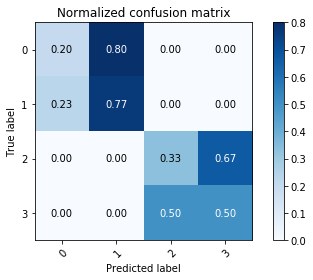

In [101]:
plot_confusion_matrix(correct_labels, preds, classes=np.unique(correct_labels), normalize=True)

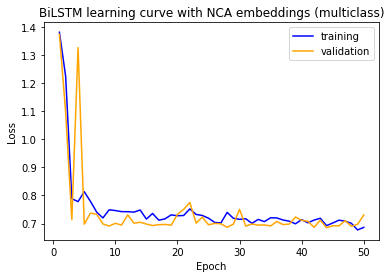

In [505]:
plt.plot(range(1,51), train_losses, color='blue')
plt.plot(range(1,51), val_losses, color='orange')
plt.title("BiLSTM learning curve with NCA embeddings (multiclass)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

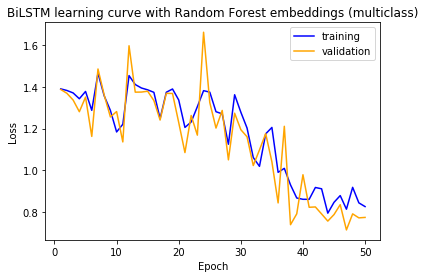

In [535]:
plt.plot(range(1,51), train_losses, color='blue')
plt.plot(range(1,51), val_losses, color='orange')
plt.title("BiLSTM learning curve with Random Forest embeddings (multiclass)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

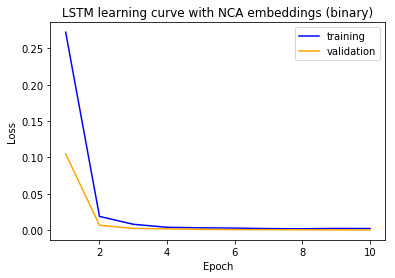

In [550]:
plt.plot(range(1,11), train_losses, color='blue')
plt.plot(range(1,11), val_losses, color='orange')
plt.title("LSTM learning curve with NCA embeddings (binary)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

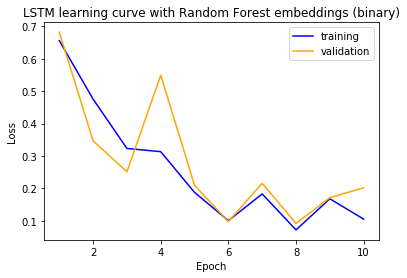

In [574]:
plt.plot(range(1,11), train_losses, color='blue')
plt.plot(range(1,11), val_losses, color='orange')
plt.title("LSTM learning curve with Random Forest embeddings (binary)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')